In [1]:

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Beatles"
!ls
basepath = '.'


Mounted at /content/drive
/content/drive/MyDrive/Beatles
Beatle_recognizer.h5  beatles_recognizer.keras	george	john  paul  ringo


In [2]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import models, optimizers, layers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from google.colab import files

In [3]:
john_folder = os.path.join(basepath, 'john')
paul_folder = os.path.join(basepath, 'paul')
george_folder = os.path.join(basepath, 'george')
ringo_folder = os.path.join(basepath, 'ringo')

(367, 224, 224, 1)
(363, 224, 224, 1)
(363, 224, 224, 1)
(360, 224, 224, 1)


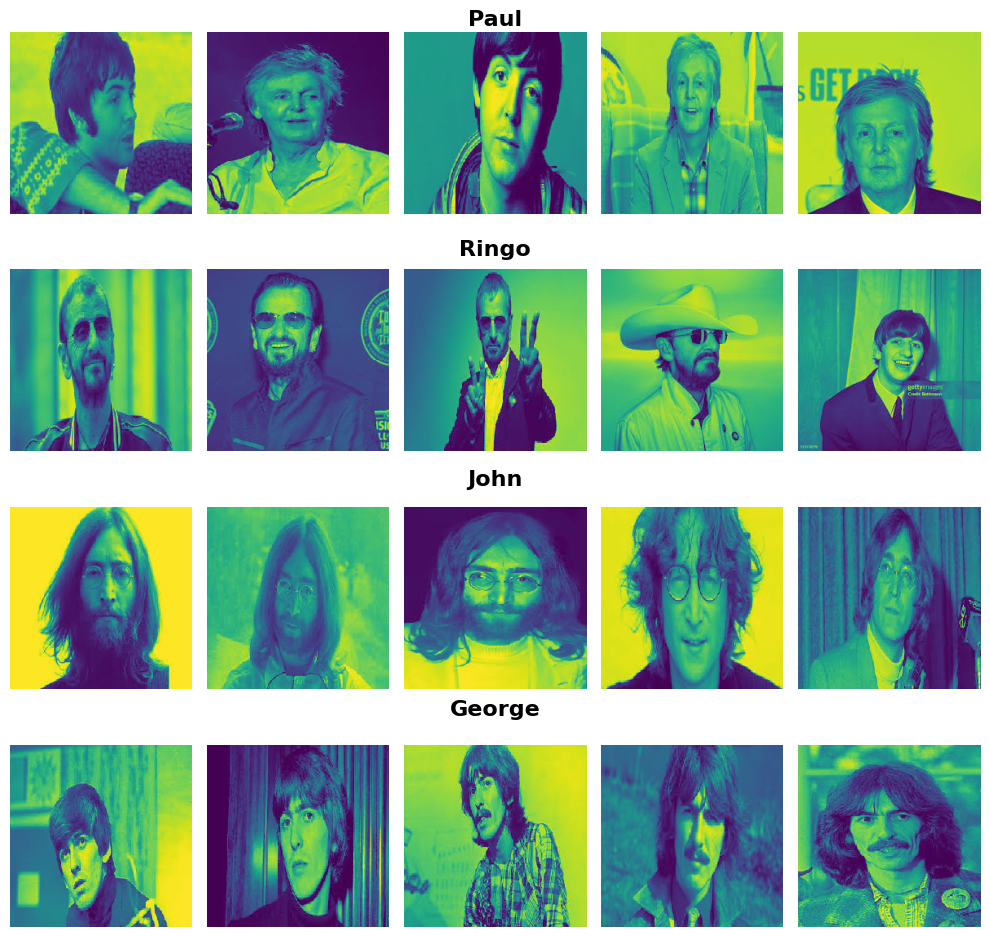

In [4]:
image_size = (224, 224)

john_images = []
paul_images = []
george_images = []
ringo_images = []


def preprocess(folder_name):
    images = []
    for filename in os.listdir(folder_name):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_name, filename)
            img = load_img(img_path, target_size=image_size, color_mode= "grayscale")
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
    return np.array(images)

john_images = preprocess(os.path.join(basepath, 'john'))
paul_images = preprocess(os.path.join(basepath, 'paul'))
george_images = preprocess(os.path.join(basepath, 'george'))
ringo_images = preprocess(os.path.join(basepath, 'ringo'))

label_map = {'john': 0, 'paul': 1, 'george': 2, 'ringo': 3}

X = np.concatenate([john_images, paul_images, george_images, ringo_images], axis=0)
y = np.array(
    [label_map['john']] * len(john_images) +
    [label_map['paul']] * len(paul_images) +
    [label_map['george']] * len(george_images) +
    [label_map['ringo']] * len(ringo_images)
)

X, y = shuffle(X, y)

y = to_categorical(y, num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

f, axarr = plt.subplots(4, 5, figsize=(10, 10))

beatles = ['Paul', 'Ringo', 'John', 'George']
image_sets = [paul_images, ringo_images, john_images, george_images]

print(paul_images.shape)
print(ringo_images.shape)
print(john_images.shape)
print(george_images.shape)

for row in range(4):
    for col in range(5):
        axarr[row][col].imshow(image_sets[row][col].squeeze())
        axarr[row][col].axis('off')

for row, name in enumerate(beatles):
    ypos = 0.96 - row * 0.23
    f.text(0.5, ypos, name, ha='center', va='center', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()

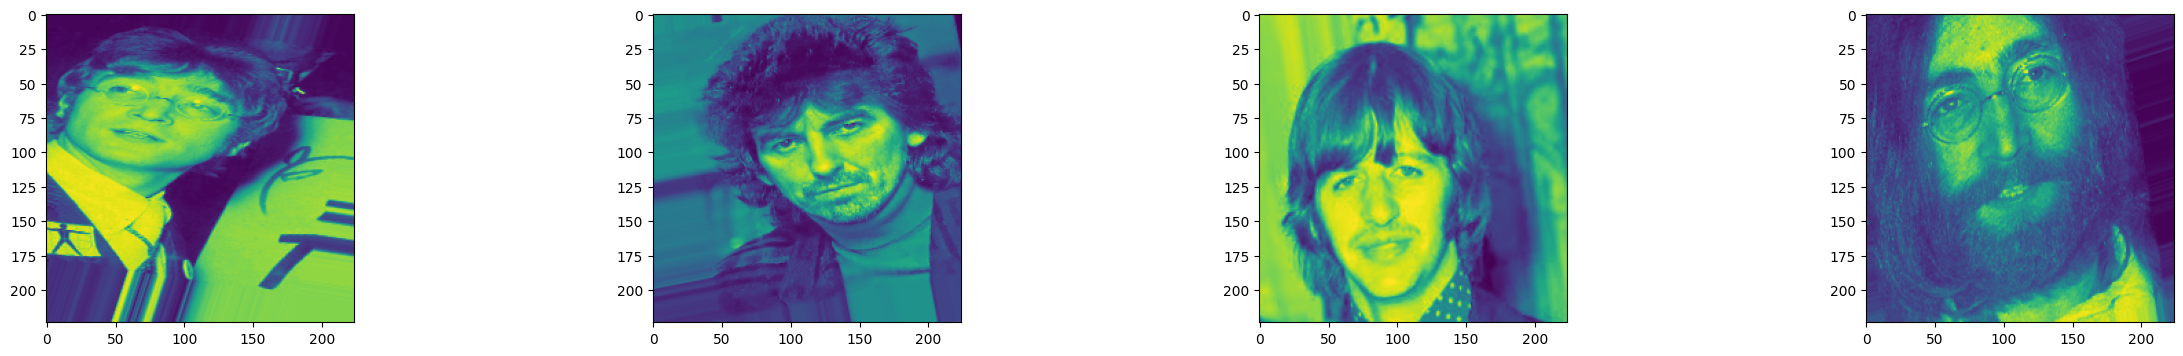

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=24)

images = next(train_generator)[0]

f, axarr = plt.subplots(1, 4, figsize=(30, 4))

for i in range(4) :
  axarr[i].imshow(images[i])

In [6]:
def build_model(input_shape=(224, 224, 1), num_classes=4):
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation='softmax'))

  return model

model = build_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,372 (49.36 MB)

 Trainable params: 12,938,372 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
"""vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_base.layers:
    layer.trainable = False

x = vgg_base.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(4, activation='softmax')(x)

model = Model(inputs=vgg_base.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()"""

"vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\n\nfor layer in vgg_base.layers:\n    layer.trainable = False\n\nx = vgg_base.output\nx = layers.Flatten()(x)\nx = layers.Dense(256, activation='relu')(x)\nx = layers.Dropout(0.5)(x)\noutput = layers.Dense(4, activation='softmax')(x)\n\nmodel = Model(inputs=vgg_base.input, outputs=output)\n\nmodel.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])\n\nmodel.summary()"

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.2465 - loss: 1.4183 - val_accuracy: 0.2752 - val_loss: 1.3915
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.3094 - loss: 1.3856 - val_accuracy: 0.2890 - val_loss: 1.3809
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.2715 - loss: 1.3848 - val_accuracy: 0.3165 - val_loss: 1.3794
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.3000 - loss: 1.3822 - val_accuracy: 0.3005 - val_loss: 1.3766
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.2960 - loss: 1.3721 - val_accuracy: 0.3096 - val_loss: 1.3781
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.3088 - loss: 1.3685 - val_accuracy: 0.3326 - val_loss: 1.3663
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.3499 - loss: 1.3583 - val_accuracy: 0.3372 - val_loss: 1.3546
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.3555 - loss: 1.3549 - val_accuracy: 0.3647 - v

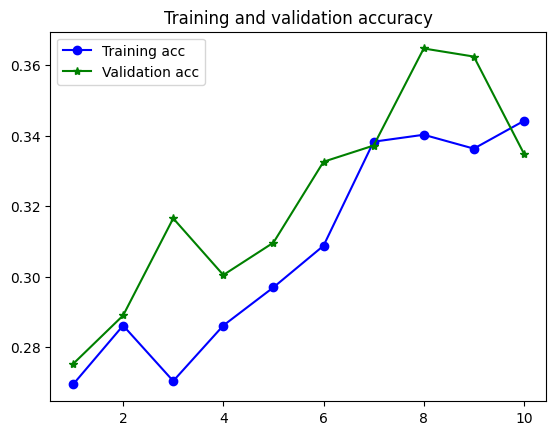

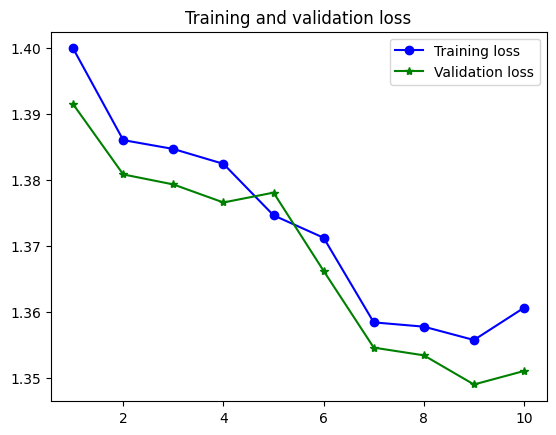

In [8]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=10, callbacks=[early_stop])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'g*-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'g*-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
class_names = ['John', 'Paul', 'George', 'Ringo']

def plot_image(i, predictions_array, true_label, img):
    true_label_idx = np.argmax(true_label[i])
    predicted_label_idx = np.argmax(predictions_array)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[i])

    color = 'blue' if predicted_label_idx == true_label_idx else 'red'
    plt.xlabel("{} {:2.0f}% (True: {})".format(
        class_names[predicted_label_idx],
        100*np.max(predictions_array),
        class_names[true_label_idx]),
        color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label_idx = np.argmax(true_label[i])

    plt.grid(False)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    thisplot[true_label_idx].set_color('blue')
    thisplot[np.argmax(predictions_array)].set_color('red')



14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


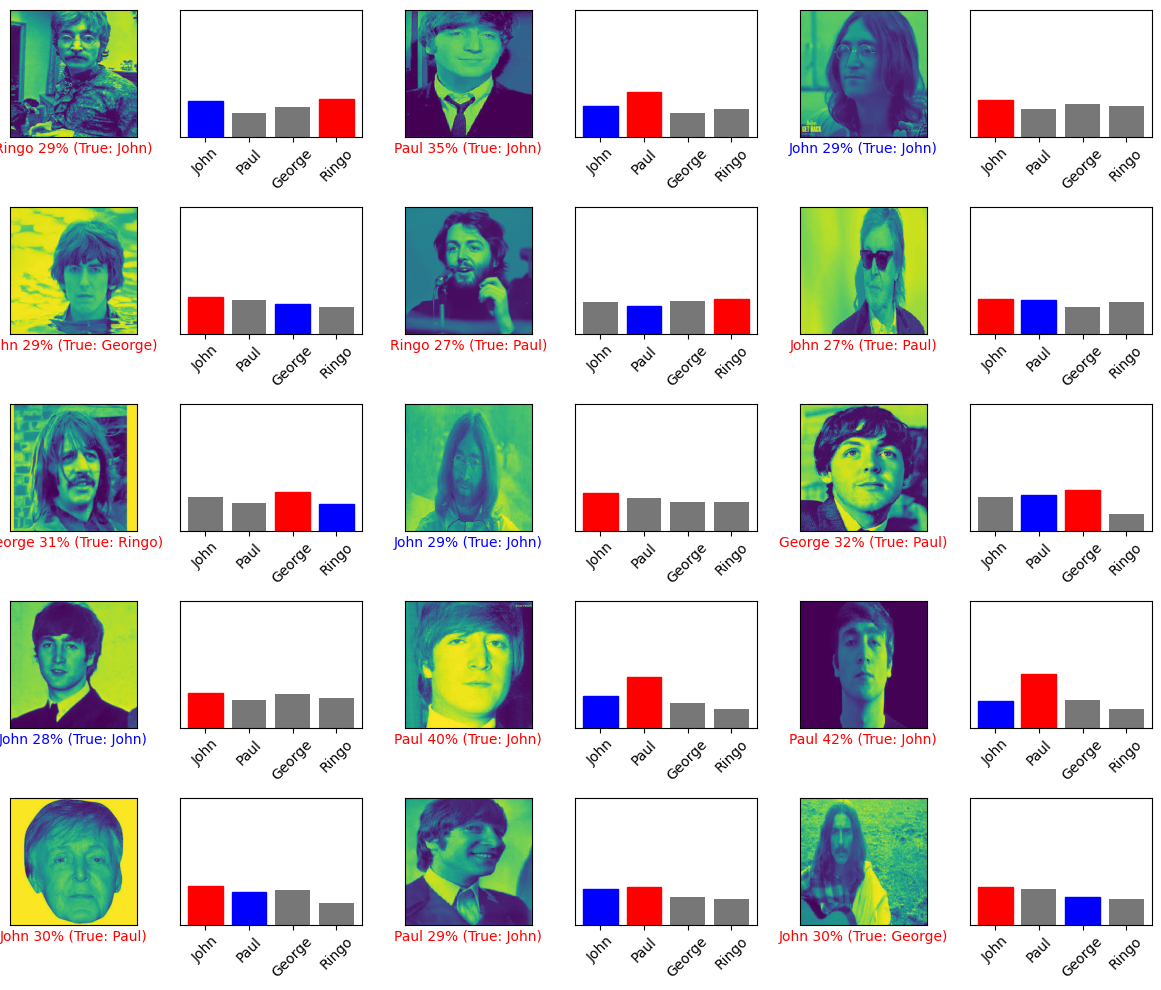

In [10]:
X_val,y_val = shuffle(X_val,y_val)

predictions = model.predict(X_val)

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_val, X_val)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_val)
plt.tight_layout()
plt.show()


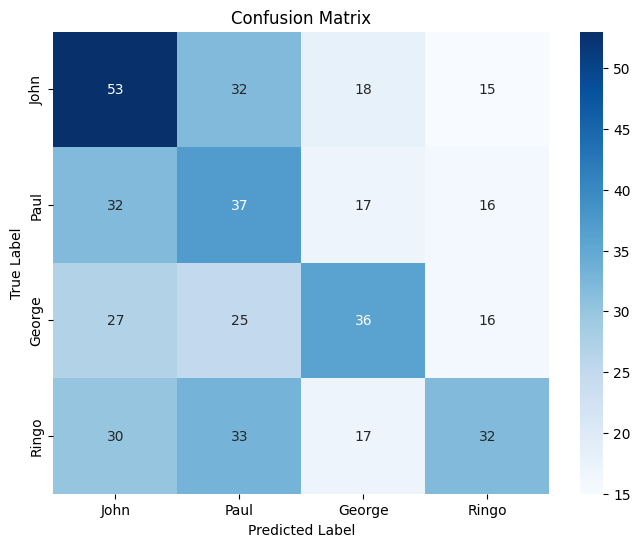

In [11]:
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ['John', 'Paul', 'George', 'Ringo']
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
model.save('beatles_recognizer.keras')
files.download('beatles_recognizer.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>